# Simple Covid19 dataset analisys

In [23]:
!date

Mon Apr 13 09:43:48 UTC 2020


In [11]:
from google.cloud import bigquery
import pandas as pd

In [12]:
client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))

query = """
SELECT * FROM `bigquery-public-data.covid19_jhu_csse.deaths` 
where province_state is null and country_region = "United Kingdom" 
or country_region = "Italy" 
or country_region = "Germany"
"""
# or country_region = "Korea, South"

query_job = client.query(
    query,
    location="US",
)  # API request - starts the query

df = query_job.to_dataframe()
df.set_index('country_region', inplace=True) # use Country as index
df.drop(
    columns=['province_state', 'latitude', 'longitude', 'location_geom'], 
    inplace=True) # drops unused columns
df.rename(index={
    'Korea, South': 'Korea',
    'United Kingdom': 'UK',},
         inplace=True)
df

Client creating using default project: raffo-bq-xperiment


,_1_22_20,_1_23_20,_1_24_20,_1_25_20,_1_26_20,_1_27_20,_1_28_20,_1_29_20,_1_30_20,_1_31_20,...,_4_3_20,_4_4_20,_4_5_20,_4_6_20,_4_7_20,_4_8_20,_4_9_20,_4_10_20,_4_11_20,_4_12_20
country_region,,,,,,,,,,,,,,,,,,,,,
Germany,0,0,0,0,0,0,0,0,0,0,...,1275,1444,1584,1810,2016,2349,2607,2767,2736,3022
Italy,0,0,0,0,0,0,0,0,0,0,...,14681,15362,15887,16523,17127,17669,18279,18849,19468,19899
UK,0,0,0,0,0,0,0,0,0,0,...,3605,4313,4934,5373,6159,7097,7978,8958,9875,10612


In [13]:
def transform(df, fn):
    '''Applies an incremental transformation to the series.
    
    Keyword arguments:
    @df: input dataframe
    @fn: the incremental transformation
        
    Examples:
    fn=lambda x,y: x - y will get the daily increase
    fn=lambda x,y: (x - y)/y will get the relative increase
    '''
    col = df.columns[1:]
    index = df.index
    transformed_series = df.apply(lambda line: [ fn(x,y) for (x,y) in (zip(line[1:], line))] , axis=1)
    transformed_df = pd.DataFrame(zip(*[country for country in transformed_series])).T
    transformed_df.set_index(index,inplace=True)
    transformed_df.columns = col
    return transformed_df   

In [14]:
linear_increase = transform(df, lambda x, y: x - y)

linear_increase

,_1_23_20,_1_24_20,_1_25_20,_1_26_20,_1_27_20,_1_28_20,_1_29_20,_1_30_20,_1_31_20,_2_1_20,...,_4_3_20,_4_4_20,_4_5_20,_4_6_20,_4_7_20,_4_8_20,_4_9_20,_4_10_20,_4_11_20,_4_12_20
country_region,,,,,,,,,,,,,,,,,,,,,
Germany,0,0,0,0,0,0,0,0,0,0,...,168,169,140,226,206,333,258,160,-31,286
Italy,0,0,0,0,0,0,0,0,0,0,...,766,681,525,636,604,542,610,570,619,431
UK,0,0,0,0,0,0,0,0,0,0,...,684,708,621,439,786,938,881,980,917,737


In [15]:
rel_increase = transform(df, lambda x, y: (x - y)/y if y >0 else 0 )

# rel_increase

In [16]:
from math import log
exp_increase = transform(df, lambda x, y: 1/log(x/y, 2) if y > 0 and x > y else None )

exp_increase

,_1_23_20,_1_24_20,_1_25_20,_1_26_20,_1_27_20,_1_28_20,_1_29_20,_1_30_20,_1_31_20,_2_1_20,...,_4_3_20,_4_4_20,_4_5_20,_4_6_20,_4_7_20,_4_8_20,_4_9_20,_4_10_20,_4_11_20,_4_12_20
country_region,,,,,,,,,,,,,,,,,,,,,
Germany,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.905760,5.568751,7.490547,5.197036,6.430622,4.534097,6.651419,11.637100,NaN,6.971778
Italy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.935049,15.286824,20.626779,17.658818,19.306207,22.247969,20.422019,22.572936,21.451543,31.654333
UK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.294492,3.865594,5.152886,8.132057,5.076959,4.889660,5.923545,5.982667,7.112169,9.629836


In [17]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10, 'figure.figsize': (10, 8)}) # adjust font and plot size
def plot_series(df):
    for loc in df.index:
        df.loc[loc].plot()
    plt.legend(loc='best');

## Daily death - by country

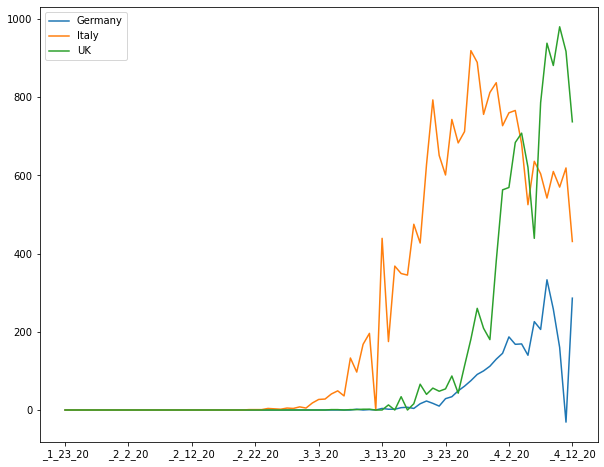

In [18]:
plot_series(linear_increase)

## Number of day to double the death count - by country
( The higher the better, means the country is flattening the curve )

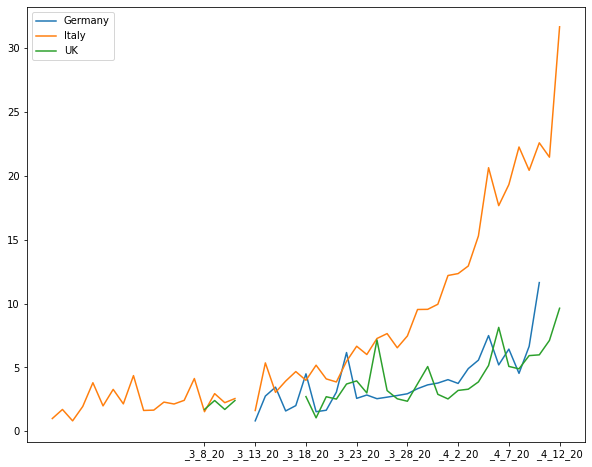

In [19]:
plot_series(exp_increase)